# Тестирование новой механики оплаты

In [2]:
import pandas as pd

## 1. А/Б тестирование 

Задача:
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### Для начала подготовим данные для тестирования:

In [3]:
groups = pd.read_csv('Проект_2_groups.csv', sep=';') # А - контрольная группа, Б - эксперимент
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
group_add = pd.read_csv('Проект_2_group_add.csv', sep=',') # Дополнительные данные спустя 2 дня
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [5]:
groups_df = pd.concat([groups, group_add]).drop_duplicates().reset_index(drop=True) 
# Объединяем даннные в один датафрейм, сбрасываем индексы, убираем дубликаты

In [6]:
active_studs = pd.read_csv('Проект_2_active_studs.csv') # Активные пользователи во время эксперимента 
active_studs.shape

(8341, 1)

In [7]:
active_studs.nunique() # Проверяем, что пользователи не повторяются 

student_id    8341
dtype: int64

In [8]:
checks = pd.read_csv('Проект_2_checks.csv', sep=';') # Информация об оплатах во время эксперимента
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [9]:
df = active_studs.merge(checks, how='left', on='student_id') 
# К данным об активных пользователях добавляем информацию об их оплатах 

In [10]:
df = df.merge(groups_df, how='left', left_on='student_id', right_on='id')\
    .drop(columns='id') # Добавляем информацию о том, к какой группе принадлежит активный пользователь 

In [11]:
df.head()

,student_id,rev,grp
0,581585,NaN,A
1,5723133,NaN,A
2,3276743,NaN,B
3,4238589,NaN,A
4,4475369,NaN,B


In [12]:
df.groupby('grp', as_index=False).student_id.count() # Количество пользователей в группах А и Б

,grp,student_id
0,A,1538
1,B,6803


In [13]:
df.isna().sum() # Считаем количество пустых значений - это пользователи, не совершившие оплату

student_id       0
rev           7949
grp              0
dtype: int64

In [14]:
df_new = df.dropna() # Чтобы сравнить именно разницу в способах оплаты убираем строки с пустыми значениями

In [15]:
df_new.groupby('grp', as_index=False).student_id.count() # Оставшееся количество пользователей в группах А и Б

,grp,student_id
0,A,78
1,B,314


In [16]:
control = df_new.query('grp == "A"') # Выделяем значения контрольной группы
control = control['rev']

In [17]:
test = df_new.query('grp == "B"') # Выделяем значения тестовой группы 
test = test['rev']

### Проводим А/Б тест

#### Проведём два А/Б теста и проверим две метрики:  
1. Средний чек
2. Конверсия в платящего 

 ### Гипотезы:
1. $H_0$ - Средние чеки в тестовой и контрольной группах равны  
   $H_1$ - Средние чеки в тестовой и контрольной группах **не** равны  
<br>   
2. $H_0$ - Конверсия в платящего в тестовой и контрольной группах равна  
   $H_1$ - Конверсия в платящего в тестовой и контрольной группах **не** равна


### 1. Равенство средних
- Для проверки гипотезы о равенстве средних чеков используем t-test:
     - При равных дисперсиях - Student's t-test
     - При разных дисперсиях или большой разнице в размерах групп - Welch's t-test

#### Проверяем нормальность распределений:

In [18]:
from scipy.stats import normaltest, anderson


k2_control, p_control = normaltest(control)   # D’Agostino K^2
k2_test, p_test = normaltest(test)

print(f"normaltest p (control) = {p_control}")
print(f"normaltest p (test)    = {p_test}")

# Дополнительно (Anderson–Darling):
ad_control = anderson(control, dist='norm')
ad_test = anderson(test, dist='norm')
print("AD stat control:", ad_control.statistic, "crit:", ad_control.critical_values)
print("AD stat test:",    ad_test.statistic, "crit:", ad_test.critical_values)

normaltest p (control) = 2.531686880422046e-07
normaltest p (test)    = 0.033445723194625424
AD stat control: 7.628197283123953 crit: [0.55  0.626 0.752 0.877 1.043]
AD stat test: 18.65982488399618 crit: [0.569 0.648 0.777 0.907 1.079]


#### Результат: **распределения не нормальны**, но тк наши выборки достаточно большие (>30) можем этим пренебречь и провести t-test

#### Визуализируем распределения тестовой и контрольной групп:

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_hist(data, title="Гистограмма распределения", bins=100):
    plt.figure(figsize=(6,3))
    sns.histplot(data, bins=bins, kde=True, color="skyblue", edgecolor="black")
    plt.title(title, fontsize=14)
    plt.xlabel("Значения")
    plt.ylabel("Частота")
    plt.grid(alpha=0.3)
    plt.show()

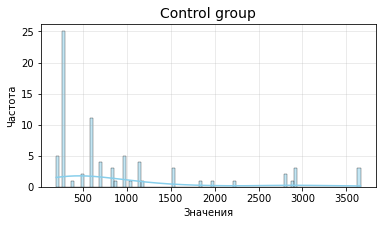

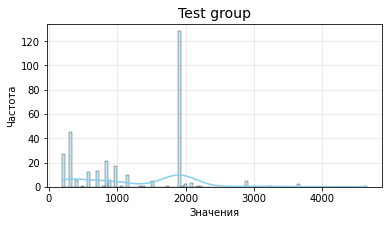

In [20]:
plot_hist(control, title="Control group")
plot_hist(test, title="Test group")

####  Проводим t-test:
Внутри функции проверяем равенство дисперсий тестом Levene, в зависимости от результата выбираем использовать поправки Уэлча или нет

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, levene

def t_test(control, test):

    # Проверка равенства дисперсий
    stat, p_levene = levene(control, test)

    if p_levene > 0.05:
        print(f"Levene p={p_levene:.4f} >> дисперсии примерно равны>> используем Student’s t-test")
        stat, p_value = ttest_ind(control, test, equal_var=True)
        test_type = "Student’s t-test"
    else:
        print(f"Levene p={p_levene:.4f} >> дисперсии различаются >> используем Welch’s t-test")
        stat, p_value = ttest_ind(control, test, equal_var=False)
        test_type = "Welch’s t-test"


    # Средние значения 
    mean_c = np.mean(control)
    mean_t = np.mean(test)
    diff_abs = mean_t - mean_c
    diff_pct = (diff_abs / mean_c * 100) if mean_c != 0 else np.nan

    #  Вывод
    print(f" Mean control: {mean_c:.4f}")
    print(f" Mean test:    {mean_t:.4f}")
    print(f" Разница средних: {diff_abs:.4f} ({diff_pct:.2f}%)")
    print(f"{test_type} p-value: {p_value:.4f}")

    if p_value < 0.05:
        print("Различия статистически значимы.")
    else:
        print("Нет статистически значимых различий.")

    return {
       "p_value": p_value,
        "mean_control": mean_c,
        "mean_test": mean_t,
        "mean_diff": diff_abs,
        "mean_diff_pct": diff_pct,
        "test_type": test_type
    }

In [22]:
t_test(control, test)

Levene p=0.0803 >> дисперсии примерно равны>> используем Student’s t-test
 Mean control: 933.5897
 Mean test:    1257.8790
 Разница средних: 324.2892 (34.74%)
Student’s t-test p-value: 0.0019
Различия статистически значимы.


{'p_value': 0.0018562025265765867,
 'mean_control': 933.5897435897435,
 'mean_test': 1257.8789920382164,
 'mean_diff': 324.2892484484729,
 'mean_diff_pct': 34.73573383545851,
 'test_type': 'Student’s t-test'}

#### Отобразим результаты на графиках:

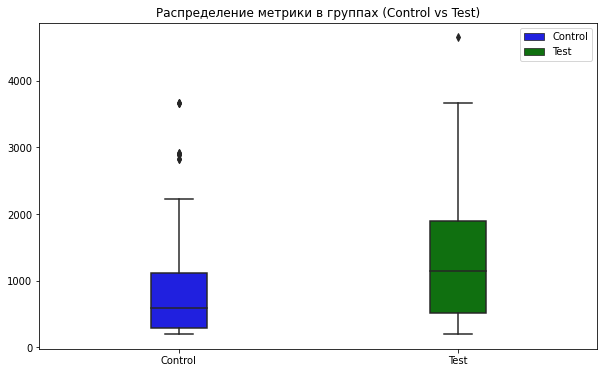

In [23]:
data = {
    "value": np.concatenate([control, test]),
    "group": ["Control"] * len(control) + ["Test"] * len(test)
}


plt.figure(figsize=(10,6))
sns.boxplot(x="group", y="value", hue="group", data=data, width=0.2, palette=["blue", "green"], dodge=False)

plt.title("Распределение метрики в группах (Control vs Test)")
plt.show()

#### Результаты t-test

Если при дизайне эксперимента были исключены сторонние влияния (например, сезонность или ошибка в сплитовании групп), то проведенный эксперимент показал, что **новая механика оплаты даёт статистически значимое улучшение в размере среднего чека.**

$H_0$ (Средние чеки в тестовой и контрольной группах равны) - **отвергается**.

### 2. Конверсия в платящего

In [24]:
df.head() # Данные с результатами эксперимента 

,student_id,rev,grp
0,581585,NaN,A
1,5723133,NaN,A
2,3276743,NaN,B
3,4238589,NaN,A
4,4475369,NaN,B


In [25]:
#добавляем колонку с информацией была оплата или нет (1 - оплата была, 0 - не было оплат)
df['rev_conv'] = df['rev'].notna().astype(int) 

#### Считаем конверсию в платящего для каждой группы:

In [26]:
conversion_rates = df.groupby("grp")['rev_conv'].mean()

print("Конверсия по группам:")
print(conversion_rates)

Конверсия по группам:
grp
A    0.050715
B    0.046156
Name: rev_conv, dtype: float64


#### Выбор теста:
Для проверки различий в бинарной метрике применяем Хи-квадрат

In [27]:
# Таблица сопряженности
contingency_table = pd.crosstab(df['grp'], df['rev_conv'])
print(contingency_table)

rev_conv     0    1
grp                
A         1460   78
B         6489  314


In [28]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi2 = {chi2:.4f}, p-value = {p:.4f}, dof = {dof}")
print("Ожидаемые значения, если бы группы не различались (H0 - верна):")
print(expected)

Chi2 = 0.4848, p-value = 0.4863, dof = 1
Ожидаемые значения, если бы группы не различались (H0 - верна):
[[1465.71897854   72.28102146]
 [6483.28102146  319.71897854]]


#### Визуализируем результаты:

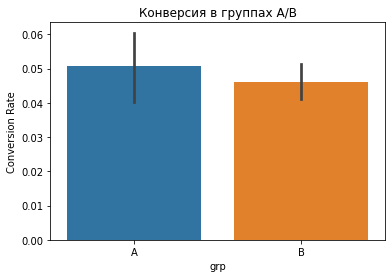

In [29]:
sns.barplot(x="grp", y="rev_conv", data=df, ci=95)
plt.title("Конверсия в группах A/B")
plt.ylabel("Conversion Rate")
plt.show()

#### Результаты:
Оснований отвергнуть $H_0$ гипотезу (Конверсия в платящего в тестовой и контрольной группах равна) **нет**.

### Выводы А/Б тестирования:
В результате анализа проведенных экспериментов мы отвергли гипотезу о равенстве средних чеков - тестовая группа показала статистически значимое улучшение. Однако, новая механика оплаты не дала улучшения на конверсию в платящего пользователя.